# Check the module versions of the HPS solver

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.2"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import jax
import jax.numpy as jnp
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt

from timeit import default_timer
import logging
logging.basicConfig(
    format="%(asctime)s.%(msecs)03d:jaxhps: %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.DEBUG
)

from examples.wave_scattering_utils import (
    solve_scattering_problem,
    load_SD_matrices,
    get_uin,
)
from examples.scattering_potentials import (
    q_gaussian_bumps,
)
from examples.plotting_utils import plot_field_for_wave_scattering_experiment

jax.config.update("jax_default_device", jax.devices("gpu")[0])
jax.config.update("jax_enable_x64", True)
# jax.config.update("XLA_PYTHON_CLIENT_MEM_FRACTION", 0.5)


import subprocess
_ =subprocess.run("hostname")
_ =subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

2025-06-30 18:31:49.767:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-30 18:31:49.769:jaxhps: DEBUG - Creating converter from 5 to 7
2025-06-30 18:31:49.770:jaxhps: DEBUG - Creating converter from 7 to 5
2025-06-30 18:31:49.771:jaxhps: DEBUG - Creating converter from 5 to 7


g18.ttic.edu
NVIDIA RTX A4000, 16376 MiB


In [2]:
from jaxhps import (
    DiscretizationNode2D,
    Domain,
    PDEProblem,
    upward_pass_subtree,
    downward_pass_subtree,
    local_solve_chunksize_2D,
)
from jaxhps.local_solve import local_solve_stage_uniform_2D_ItI
from jaxhps.merge import merge_stage_uniform_2D_ItI
from jaxhps.down_pass import down_pass_uniform_2D_ItI
from examples.wave_scattering_utils import (
    get_DtN_from_ItI,
    setup_scattering_lin_system,
    get_uin_and_normals,
    get_uin,
    get_scattering_uscat_impedance,
)

from wave_scattering.interp_utils import (
    prep_grids_cheb_2d,
    prep_grids_unif_2d,
    reorder_tree_cheb_for_hps,
)

from wave_scattering.interp_ops import (
    QuadtreeToUniformFixedDomain,
    UniformToQuadtree,
)

In [3]:
bump_center = jnp.array([0.05, 0.2])
# bump_center = jnp.array([0.0, 0.0])
amplitude = 2
# sigma = 0.15
sigma = 0.07
q_fn_handle = lambda x: amplitude * jnp.exp(-0.5*jnp.sum( ((x-bump_center)/sigma)**2 ,axis=-1))

# q_fn_handle = lambda x: q_gaussian_bumps(1.5 * x)

In [4]:
tree_n_per_leaf = 16
tree_L = 2
tree_p = 16
tree_n = 2**tree_L * tree_n_per_leaf
clip_n = 64

domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
tree_root = DiscretizationNode2D(*domain_bounds)
tree_domain = Domain(p=tree_p, q=tree_p-2, root=tree_root, L=tree_L)

print(f"L={tree_L}, N={tree_n}")

L=2, N=64


In [5]:
# Grid setup
cell_offset = 0

# leaf-level
leaf_cheb_grids = prep_grids_cheb_2d(0, tree_p, domain_bounds)
leaf_cheb_x  = leaf_cheb_grids[0]
leaf_cheb_y  = leaf_cheb_grids[1]
leaf_cheb_xy = leaf_cheb_grids[2]
leaf_unif_grids = prep_grids_unif_2d(0, tree_n_per_leaf, domain_bounds, rel_offset=cell_offset)
leaf_unif_x  = leaf_unif_grids[0]
leaf_unif_y  = leaf_unif_grids[1]
leaf_unif_xy = leaf_unif_grids[2]

# Tree level
tree_cheb_grids = prep_grids_cheb_2d(tree_L, tree_p, domain_bounds)
tree_cheb_x  = tree_cheb_grids[0]
tree_cheb_y  = tree_cheb_grids[1]
tree_cheb_xy = tree_cheb_grids[2]

tree_unif_grids = prep_grids_unif_2d(tree_L, tree_n_per_leaf, domain_bounds, rel_offset=cell_offset)
tree_unif_x  = tree_unif_grids[0]
tree_unif_y  = tree_unif_grids[1]
tree_unif_xy = tree_unif_grids[2]

hps_cheb_xy = reorder_tree_cheb_for_hps(tree_cheb_xy, tree_L, tree_p)

In [6]:
%%time
QtU = QuadtreeToUniformFixedDomain(
    tree_L, tree_p, tree_n_per_leaf,
    rel_offset=cell_offset
)

CPU times: user 343 ms, sys: 22.2 ms, total: 365 ms
Wall time: 439 ms


In [7]:
%%time
# UtQ = UniformToQuadtree(tree_L, tree_p, tree_n_per_leaf, domain_bounds, rel_offset=cell_offset)
UtQ = UniformToQuadtree(
    tree_L, tree_p, clip_n,
    domain_bounds=domain_bounds,
    rel_offset=cell_offset
)

CPU times: user 2.03 s, sys: 168 ms, total: 2.2 s
Wall time: 1.24 s


In [8]:
# 0. Compute reference values
ref_q_tree_unif = q_fn_handle(tree_unif_xy).reshape(tree_n, tree_n) # .reshape(4**tree_L, -1)
ref_q_tree_cheb = q_fn_handle(tree_domain.interior_points).reshape(4**tree_L, -1)

In [9]:
# 1. Uniform -> Quadtree
q_tree_cheb_utq = UtQ.apply(ref_q_tree_unif)

utq_err = jnp.linalg.norm(ref_q_tree_cheb-q_tree_cheb_utq) / jnp.linalg.norm(ref_q_tree_cheb)
print(f"Uniform->Quadtree relative error: {utq_err:.5e}")

Uniform->Quadtree relative error: 2.70756e-04


In [10]:
# 2. Quadtree -> Uniform (on orig data)
q_unif_qtu_orig = QtU.apply(ref_q_tree_cheb) # .reshape(4**tree_L, -1)

qtu_orig_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_orig) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (orig)->Uniform relative error: {qtu_orig_err:.5e}")

Quadtree (orig)->Uniform relative error: 1.75779e-08


In [11]:
# 3. Quadtree -> Uniform (on Quadtree to Uniform data)
q_unif_qtu_reco = QtU.apply(q_tree_cheb_utq) # .reshape(4**tree_L, -1)

qtu_reco_err = jnp.linalg.norm(ref_q_tree_unif-q_unif_qtu_reco) / jnp.linalg.norm(ref_q_tree_unif)
print(f"Quadtree (reco)->Uniform relative error: {qtu_reco_err:.5e}")

Quadtree (reco)->Uniform relative error: 2.84913e-04


## HPS exterior solver

In [12]:
from exterior_solver.utils.ScatteringProblem import ScatteringProblem
from exterior_solver.utils.gen_SD_exterior import (
    gen_D_exterior,
    gen_S_exterior,
)
from exterior_solver.exterior_solver_for_Olivia import (
    get_uscat_and_dn,
    forward_model_exterior,
)

In [13]:
# Basic problem dimensions
k_str = "20"
k = float(k_str)
R = 100

N_x = 192
L = 4
p = 12 # chebyshev order
pm2 = p-2 # gauss-legendre order
n_per_leaf = int(np.round(N_x / (2**L)))
nside = 2**L
n = nside * n_per_leaf
main_clip_n = 192

N_s = 192
N_r = N_s
source_dirs = jnp.pi/2-jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)
# source_dirs = jnp.linspace(0, 2*jnp.pi, N_s, endpoint=False)

# q_fn = lambda x: q_gaussian_bumps(0.7*x)
q_fn = q_fn_handle
main_domain_bounds = jnp.array([-0.5, 0.5, -0.5, 0.5])
# main_hps_domain_bounds = jnp.array([-1., 1., -1., 1.])
main_root = DiscretizationNode2D(*main_domain_bounds)
# orig_domain = Domain(p=p, q=p - 2, root=orig_root, L=L) # [-0.5, 0.5]^2
main_domain = Domain(p=p, q=p - 2, root=main_root, L=L) # Extended grid

main_unif_x, main_unif_y, main_unif_xy = prep_grids_unif_2d(L, n_per_leaf, main_domain_bounds, rel_offset=0)
main_cheb_x, main_cheb_y, main_cheb_xy = prep_grids_cheb_2d(L, p, main_domain_bounds)
main_hps_cheb_xy = reorder_tree_cheb_for_hps(main_cheb_xy, L, p)

ref_main_q_cheb = q_fn(main_domain.interior_points)
ref_main_q_unif = q_fn(main_unif_xy).reshape(N_x, N_x) # .reshape(4**L, n_per_leaf**2)

In [14]:
%%time
main_QtU = QuadtreeToUniformFixedDomain(L, p, n_per_leaf, rel_offset=0)

CPU times: user 524 ms, sys: 20 ms, total: 544 ms
Wall time: 705 ms


In [15]:
%%time
# main_UtQ = UniformToQuadtree(L, p, n_per_leaf, main_domain_bounds, rel_offset=0) # slow to set up... maybe can do on the GPU?

main_UtQ = UniformToQuadtree(
    L, p, N_x,
    domain_bounds=domain_bounds,
    rel_offset=cell_offset
)


CPU times: user 3.23 s, sys: 446 ms, total: 3.68 s
Wall time: 1.96 s


In [16]:
# Check the Uniform -> Quadtree error quickly...
q_main_cheb_utq = main_UtQ.apply(ref_main_q_unif)
utq_err = jnp.linalg.norm(ref_main_q_cheb-q_main_cheb_utq) / jnp.linalg.norm(ref_main_q_cheb)
print(f"Uniform->Quadtree relative error: {utq_err:.5e}")

Uniform->Quadtree relative error: 2.84314e-05


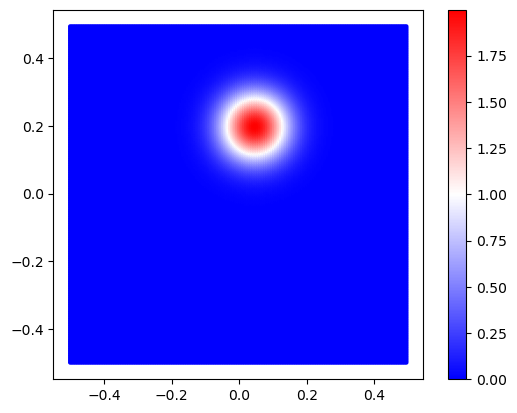

In [17]:
cb = plt.scatter(
    *main_unif_xy.T,
    c=(ref_main_q_unif).flatten(),
    cmap="bwr",
    s=5,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

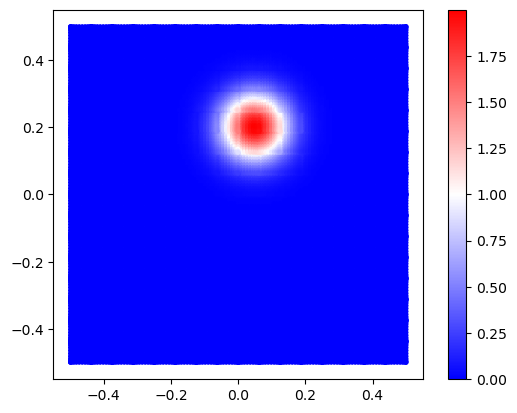

In [18]:
cb = plt.scatter(
    *main_hps_cheb_xy.T,
    c=main_UtQ.apply(ref_main_q_unif).flatten(),
    cmap="bwr",
    s=5,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

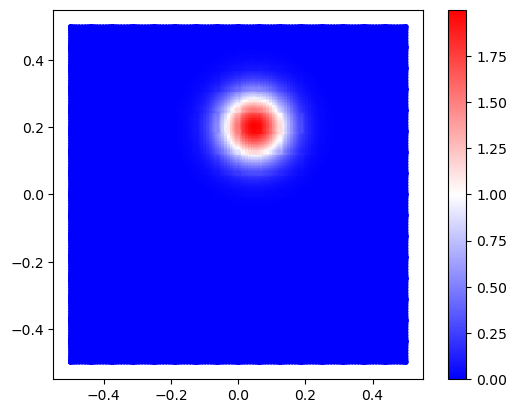

In [19]:
cb = plt.scatter(
    *main_hps_cheb_xy.T,
    c=ref_main_q_cheb.flatten(),
    cmap="bwr",
    s=5,
)
plt.gca().set_aspect(1)
plt.colorbar()
plt.show()

In [20]:
# Load S and D matrices for the boundary integral equation
S_D_matrices_fp = os.path.join(
    "data/wave_scattering/SD_matrices",
    f"SD_k{k_str}_n{pm2}_nside{nside}_dom1.mat"
)
S_int, D_int = load_SD_matrices(S_D_matrices_fp)

# Generate the exterior S, D matrices
S_ext = gen_S_exterior(domain=main_domain, k=k, rad=R, source_dirs=source_dirs)
D_ext = gen_D_exterior(domain=main_domain, k=k, rad=R, source_dirs=source_dirs)

In [21]:
%%time
d_xx_evals = jnp.ones_like(main_domain.interior_points[..., 0])
d_yy_evals = jnp.ones_like(main_domain.interior_points[..., 1])
pde_problem = PDEProblem(
    domain=main_domain,
    D_xx_coefficients=d_xx_evals,
    D_yy_coefficients=d_yy_evals,
    eta=k,
    use_ItI=True,
)

CPU times: user 34.7 s, sys: 440 ms, total: 35.1 s
Wall time: 26.4 s


In [22]:
%%time
scat_problem = ScatteringProblem(
    pde_problem=pde_problem,
    S_int=S_int,
    D_int=D_int,
    S_ext=S_ext,
    D_ext=D_ext,
    target_points_reg=None,
    source_dirs=source_dirs,
)

2025-06-30 18:32:35.160:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 144)
2025-06-30 18:32:35.232:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (256, 144)
2025-06-30 18:32:35.234:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (256, 144, 2)


CPU times: user 313 ms, sys: 44.5 ms, total: 357 ms
Wall time: 443 ms


In [23]:
%%time
usc_ext_hps = forward_model_exterior(
    scattering_problem=scat_problem, q=ref_main_q_cheb,
)

2025-06-30 18:32:35.240:jaxhps: INFO - Starting exterior solve...
2025-06-30 18:32:35.294:jaxhps: INFO - Building the solver...
2025-06-30 18:32:36.391:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)
2025-06-30 18:32:43.425:jaxhps: INFO - Computing DtN from ItI...
2025-06-30 18:32:43.646:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-06-30 18:32:43.954:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-06-30 18:32:44.761:jaxhps: INFO - Mapping to exterior points...
2025-06-30 18:32:44.834:jaxhps: INFO - Finished and returning!


CPU times: user 8.38 s, sys: 242 ms, total: 8.62 s
Wall time: 9.6 s


In [24]:
%%time
usc_ext_hps = forward_model_exterior(
    scattering_problem=scat_problem,
    # q=ref_main_q_cheb,
    q=main_UtQ.apply(ref_main_q_unif),
)
d_rs_hps = np.array(usc_ext_hps).T

2025-06-30 18:32:44.912:jaxhps: INFO - Starting exterior solve...
2025-06-30 18:32:44.918:jaxhps: INFO - Building the solver...
2025-06-30 18:32:44.927:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)
2025-06-30 18:32:44.993:jaxhps: INFO - Computing DtN from ItI...
2025-06-30 18:32:44.995:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-06-30 18:32:44.997:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-06-30 18:32:45.000:jaxhps: INFO - Mapping to exterior points...
2025-06-30 18:32:45.020:jaxhps: INFO - Finished and returning!


CPU times: user 136 ms, sys: 52.7 ms, total: 189 ms
Wall time: 270 ms


In [25]:
# Query JAX VRAM usage
gpu_list = [device for device in jax.devices("gpu")]
gpu_stats = [gpu.memory_stats() for gpu in gpu_list]
gpu_vram_use_mb  = [gpu_stat["bytes_in_use"] >> 20 for gpu_stat in gpu_stats]
gpu_vram_limit_mb = [gpu_stat["bytes_limit"] >> 20 for gpu_stat in gpu_stats]
print(f"VRAM Usage per GPU (in MBs): {gpu_vram_use_mb}")

VRAM Usage per GPU (in MBs): [230]


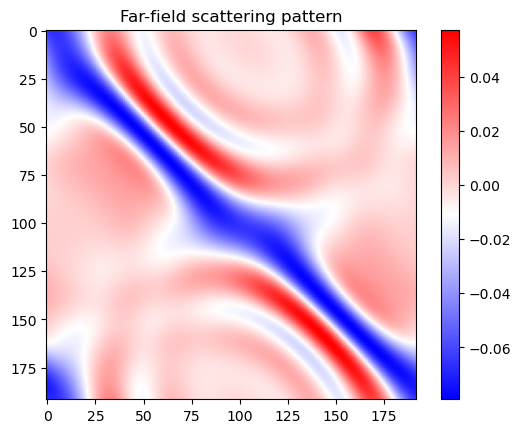

In [26]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(d_rs_hps), cmap="bwr")
plt.colorbar()
plt.show()

## Work on the new module version of the exterior scatterer...

In [40]:
from typing import Tuple
class HPSScatteringSolver():
    def __init__(
        self, 
        L, p, unif_n, k,
        S_int, D_int,
        source_dirs=None,
        receiver_dirs=None,
        S_ext=None, D_ext=None,
        N_r=None, N_s=None, receiver_radius=100,
        unif_domain_bounds=(-0.5, 0.5, -0.5, 0.5),
        quad_domain_bounds=(-0.5, 0.5, -0.5, 0.5),
        UtQ=None,
        # QtU=None,
    ):
        """Set up the HPS solver
        """
        self.L = L
        self.p = p
        # self.n_per_leaf = n_per_leaf
        # self.n = 2**L * n_per_leaf
        self.n = unif_n
        self.n_per_leaf = unif_n // 2**L
        self.k = k
        self.receiver_radius = receiver_radius

        self.leaf_bounds = (-1., 1., -1., 1.)
        self.unif_domain_bounds = jnp.array(unif_domain_bounds)
        self.quad_domain_bounds = jnp.array(quad_domain_bounds)
        self.root = DiscretizationNode2D(*self.quad_domain_bounds)
        self.domain = Domain(p=p, q=p - 2, root=self.root, L=L)

        # Calculate the grids in case they'll be useful later...
        self.leaf_unif_x, self.leaf_unif_y, self.leaf_unif_xy = prep_grids_unif_2d(
            0, self.n_per_leaf, domain_bounds=self.leaf_bounds, rel_offset=0,
        )
        self.leaf_cheb_x, self.leaf_cheb_y, self.leaf_cheb_xy = prep_grids_cheb_2d(
            0, self.p, domain_bounds=self.leaf_bounds
        )
        self.tree_unif_x, self.tree_unif_y, self.tree_unif_xy = prep_grids_unif_2d(
            0, self.n, domain_bounds=self.unif_domain_bounds, rel_offset=0,
        )
        # self.tree_quad_unif_x, self.tree_quad_unif_y, self.tree_quad_unif_xy = prep_grids_unif_2d(
        #     self.L, self.n_per_leaf, domain_bounds=self.quad_domain_bounds, rel_offset=0,
        # )
        self.tree_cheb_x, self.tree_cheb_y, self.tree_cheb_xy = prep_grids_cheb_2d(
            self.L, self.p, domain_bounds=self.quad_domain_bounds
        )

        # Expect N_r or receiver_dirs and N_s or source_dirs
        # If both are given but conflict, the values from the {source,receiver}_dirs will be used
        assert not (N_r is None and receiver_dirs is None)
        assert not (N_s is None and source_dirs is None)
        self.N_r = N_r if N_r is not None else receiver_dirs.shape[0]
        self.N_s = N_s if N_s is not None else source_dirs.shape[0]
        self.receiver_dirs = receiver_dirs if receiver_dirs is not None else \
            jnp.pi/2-jnp.linspace(0, 2*jnp.pi, self.N_r, endpoint=False)
        self.source_dirs = source_dirs if source_dirs is not None else \
            jnp.pi/2-jnp.linspace(0, 2*jnp.pi, self.N_s, endpoint=False)

        # Save the interior S, D matrices
        self.S_int = S_int
        self.D_int = D_int

        # Compute the exterior S, D matrices in case they were not already passed
        self.S_ext = S_ext if S_ext is not None else \
            gen_S_exterior(
                domain=self.domain,
                k=k,
                rad=receiver_radius,
                source_dirs=self.receiver_dirs
            )
        self.D_ext = D_ext if D_ext is not None else \
            gen_D_exterior(
                domain=self.domain,
                k=k,
                rad=receiver_radius,
                source_dirs=self.receiver_dirs
            )

        # Set up the PDE Problem object
        self.d_xx_evals = jnp.ones_like(self.domain.interior_points[..., 0])
        self.d_yy_evals = jnp.ones_like(self.domain.interior_points[..., 0])
        self.pde_problem = PDEProblem(
            domain=self.domain,
            D_xx_coefficients=self.d_xx_evals,
            D_yy_coefficients=self.d_yy_evals,
            eta=self.k,
            use_ItI=True,
        )

        # Set up the Scattering Problem object
        self.scat_problem = ScatteringProblem(
            pde_problem=self.pde_problem,
            S_int=self.S_int,
            D_int=self.D_int,
            S_ext=self.S_ext,
            D_ext=self.D_ext,
            target_points_reg=None,
            source_dirs=self.source_dirs,
        )
        self.UtQ = UtQ if UtQ is not None else \
            UniformToQuadtree(
                self.L, self.p, self.n,
                self.unif_domain_bounds,
                self.quad_domain_bounds,
                rel_offset=0,
            )
        # # in case I need this later...
        # self.QtU = QtU if QtU is not None else \
        #     QuadtreeToUniform(
        #         self.L, self.p, self.n_per_leaf, self.n,
        #         quad_domain_bounds=self.quad_domain_bounds,
        #         clip_domain_bounds=self.clip_domain_bounds,
        #         rel_offset=0,
        #     )

    def solve_exterior(self, q: jax.Array, quadtree_in=False) -> Tuple[jax.Array]:
        """Solve for uscat on the exterior for the values at the receivers
        Note: returns usc_ext_hps and also d_rs, which has its axes flipped
        to match the format of the Lippmann-Schwinger solver's outputs
        Returns both to hopefully reduce the chance of confusion later on...
        """
        q_quadtree = q if quadtree_in else self.UtQ.apply(q)
        usc_ext_hps = forward_model_exterior(
            scattering_problem=self.scat_problem, q=q_quadtree,
        )
        d_rs_hps = usc_ext_hps.T
        logging.info(f"Returning usc_ext_hps and d_rs_hps")
        return usc_ext_hps, d_rs_hps

    def solve_interior(self, q: jax.Array) -> Tuple[jax.Array]:
        """Solve for uscat on the interior of the domain
        Not implemented so far...
        """
        pass
                

In [45]:
%%time
hps_scattering_solver = HPSScatteringSolver(
    L=L, p=p, unif_n=N_x, k=k,
    S_int=S_int,
    D_int=D_int,
    N_r=N_r,
    N_s=N_s,
    unif_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    quad_domain_bounds = (-0.5, 0.5, -0.5, 0.5),
    # UtQ=main_UtQ, # optional
)

2025-06-30 18:34:44.779:jaxhps: INFO - ScatteringProblem: cheby_weights_2D_rearranged shape: (1, 144)
2025-06-30 18:34:44.781:jaxhps: INFO - ScatteringProblem: self.quad_weights_hps shape: (256, 144)
2025-06-30 18:34:44.783:jaxhps: INFO - ScatteringProblem: self.pde_problem.domain.interior_points.shape: (256, 144, 2)


CPU times: user 3.3 s, sys: 482 ms, total: 3.78 s
Wall time: 1.71 s


In [46]:
%%time
_, d_rs_hps_wrapped = hps_scattering_solver.solve_exterior(ref_main_q_unif)

2025-06-30 18:34:45.990:jaxhps: INFO - Starting exterior solve...
2025-06-30 18:34:45.994:jaxhps: INFO - Building the solver...
2025-06-30 18:34:46.004:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)
2025-06-30 18:34:46.014:jaxhps: INFO - Computing DtN from ItI...
2025-06-30 18:34:46.016:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-06-30 18:34:46.018:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-06-30 18:34:46.075:jaxhps: INFO - Mapping to exterior points...
2025-06-30 18:34:46.096:jaxhps: INFO - Finished and returning!
2025-06-30 18:34:46.193:jaxhps: INFO - Returning usc_ext_hps and d_rs_hps


CPU times: user 137 ms, sys: 76.2 ms, total: 214 ms
Wall time: 280 ms


In [47]:
%%time
_, d_rs_hps_wrapped = hps_scattering_solver.solve_exterior(ref_main_q_unif)

2025-06-30 18:34:46.278:jaxhps: INFO - Starting exterior solve...
2025-06-30 18:34:46.282:jaxhps: INFO - Building the solver...
2025-06-30 18:34:46.290:jaxhps: DEBUG - merge_stage_uniform_2D_ItI: T_arr.shape = (256, 40, 40)
2025-06-30 18:34:46.295:jaxhps: INFO - Computing DtN from ItI...
2025-06-30 18:34:46.297:jaxhps: INFO - Computing uin and uin_dn on the boundary
2025-06-30 18:34:46.298:jaxhps: INFO - Computing uscat values and normal derivatives on the boundary...
2025-06-30 18:34:46.348:jaxhps: INFO - Mapping to exterior points...
2025-06-30 18:34:46.365:jaxhps: INFO - Finished and returning!
2025-06-30 18:34:46.367:jaxhps: INFO - Returning usc_ext_hps and d_rs_hps


CPU times: user 77.9 ms, sys: 52.7 ms, total: 131 ms
Wall time: 168 ms


In [48]:
# Query JAX VRAM usage
gpu_list = [device for device in jax.devices("gpu")]
gpu_stats = [gpu.memory_stats() for gpu in gpu_list]
gpu_vram_use_mb  = [gpu_stat["bytes_in_use"] >> 20 for gpu_stat in gpu_stats]
gpu_vram_limit_mb = [gpu_stat["bytes_limit"] >> 20 for gpu_stat in gpu_stats]
print(f"VRAM Usage per GPU (in MBs): {gpu_vram_use_mb}")

VRAM Usage per GPU (in MBs): [671]


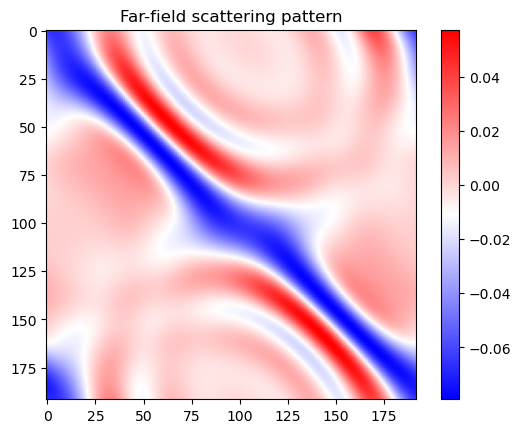

In [49]:
plt.title("Far-field scattering pattern")
plt.imshow(jnp.real(d_rs_hps), cmap="bwr")
plt.colorbar()
plt.show()

## Compare against Lippmann-Schwinger solver

In [50]:
import torch
import scipy.sparse.linalg
import sys, os, importlib.util

def module_importer(module_name, target_path):
    # See https://stackoverflow.com/questions/67631/how-can-i-import-a-module-dynamically-given-the-full-path
    target_path = os.path.abspath(os.path.expanduser(target_path))
    spec = importlib.util.spec_from_file_location(module_name, target_path)
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

solvers = module_importer ("solvers", "~/rlc-repo/solvers/__init__.py")
src = module_importer ("src", "~/rlc-repo/src/__init__.py")
from solvers.integral_equation.HelmholtzSolverDifferentiable import (
    setup_differentiable_solver,
    HelmholtzSolverDifferentiable,
    PytorchPDESolver,
    NP_CDTYPE, TORCH_CDTYPE, TORCH_RDTYPE,
)

from src.utils.plotting_utils import plot_row
from src.utils.vram_info import get_memory_info, free_vram
from src.data.data_io import load_hdf5_to_dict, load_multifreq_dataset

import os
import sys
import time
# import tqdm
import logging
from typing import Tuple, Callable, Dict
import IPython
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

get_memory_info()

import subprocess
_ = subprocess.run("hostname")
_ = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.total",  "--format=csv,noheader"])

RAM Used (MB): 9758
VRAM (MB): 4090 free of 4386 reserved; 295 allocated out of 16101 total
g18.ttic.edu
NVIDIA RTX A4000, 16376 MiB


In [51]:
_ = subprocess.run(["nvidia-smi", "--query-gpu=gpu_name,memory.used,memory.total", "--format=csv"])
free_vram()
get_memory_info()

name, memory.used [MiB], memory.total [MiB]
NVIDIA RTX A4000, 7880 MiB, 16376 MiB
RAM Used (MB): 9751
VRAM (MB): 378 free of 674 reserved; 295 allocated out of 16101 total


In [52]:
nu_solver  = k / (2*np.pi)
spatial_domain_max = 0.5
receiver_radius = R
q_si  = np.array(ref_main_q_unif)

print(f"Use frequency {nu_solver}*2pi")
solver_obj = setup_differentiable_solver(
    N_x, spatial_domain_max, nu_solver, receiver_radius,
    prepare_half_grid=True, device=device,
)

Use frequency 3.183098861837907*2pi
Calling find_diag_correction(h=5.2083e-03, frequency=20.00)...
Calling find_diag_correction(h=1.0417e-02, frequency=20.00)...


In [53]:
restart = 2000 # 0 # 1000 # try not restarting...
batch_size = 96
max_iter = 20_000

rtol_low = 1e-6
verbose = False

# Extra evaluation information
uin = solver_obj._get_uin(torch.tensor(solver_obj.source_dirs, device=device))
uin_int_ls = jnp.array(uin.detach().cpu().numpy()).T.reshape(N_x, N_x, N_s)

tq_si = torch.tensor(q_si, dtype=torch.float, device=device, requires_grad=False)
tqf_si = tq_si.flatten().unsqueeze(-1) # flattened
b_si  = -(solver_obj.frequency**2 * tqf_si * uin.permute(1, 0)).to(TORCH_CDTYPE)

def _matvec_from_torch_si(x: torch.Tensor, so=solver_obj) -> torch.Tensor:
    g_out = so._G_apply(x)
    y = x + (so.frequency**2 * tqf_si * g_out).to(TORCH_CDTYPE)
    return y

t0 = time.perf_counter()
d_rs_low, sigma_low = solver_obj.Helmholtz_solve_exterior_batched(
    tq_si,
    batch_size=batch_size,
    rtol=rtol_low,
    linsys_solver="bicgstab",
    max_iter=max_iter,
    return_as_torch=False,
    return_sigma=True,
    error_unless_converged=False,
    convergence_by_dir=True,
    use_half_grid=True, # try not to boost the accuracy too much
    half_grid_tol_ratio=1,
    report_status=True,
    verbose=verbose,
    restart=restart,
)
t1 = time.perf_counter()
usc_ext_ls = jnp.array(d_rs_low) # .T
usc_int_ls = jnp.array(
    solver_obj._G_apply(torch.tensor(sigma_low,device=device).T)
    .reshape(N_x, N_x, N_s)
    .detach().cpu().numpy()
)
utot_int_ls = usc_int_ls + uin_int_ls

Asig_low   = _matvec_from_torch_si(torch.tensor(sigma_low, device=device).T)
resid_low  = torch.norm( Asig_low - b_si , dim=0 ) / torch.norm(b_si, dim=0)
resid_low_min = resid_low.min().item()
resid_low_max = resid_low.max().item()
print(f"BiCGSTAB at rtol={rtol_low:.2e}: PDE solver ran for {t1-t0:.2f}s")
print(f"Relative residuals range between {resid_low_min:.3e} to {resid_low_max:.3e}")

2025-06-30 18:34:52.963:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)
2025-06-30 18:34:53.067:jaxhps: INFO - bicgstab exited after 7 iterations with status optimal
2025-06-30 18:34:53.068:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-06-30 18:34:53.142:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 7 iterations with status optimal


2025-06-30 18:34:53.393:jaxhps: INFO - bicgstab exited after 4 iterations with status optimal
2025-06-30 18:34:53.395:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-06-30 18:34:53.397:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)
2025-06-30 18:34:53.493:jaxhps: INFO - bicgstab exited after 7 iterations with status optimal
2025-06-30 18:34:53.494:jaxhps: DEBUG - _solve_Helmholtz_inv: returning
2025-06-30 18:34:53.570:jaxhps: DEBUG - _solve_Helmholtz_inv: starting (using bicgstab)


bicgstab exited after 4 iterations with status optimal
bicgstab exited after 7 iterations with status optimal


2025-06-30 18:34:53.817:jaxhps: INFO - bicgstab exited after 4 iterations with status optimal
2025-06-30 18:34:53.819:jaxhps: DEBUG - _solve_Helmholtz_inv: returning


bicgstab exited after 4 iterations with status optimal
BiCGSTAB at rtol=1.00e-06: PDE solver ran for 0.90s
Relative residuals range between 3.210e-07 to 4.550e-07


In [54]:
usc_int_ls.shape

(192, 192, 192)

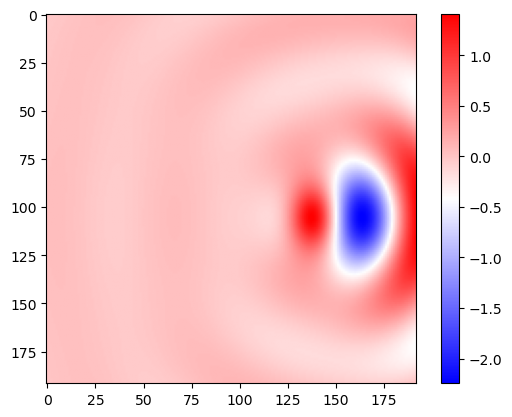

In [55]:
plt.imshow(jnp.real(usc_int_ls[:,:, 0]), cmap="bwr")
plt.colorbar()
plt.show()

## Far-field comparisons

In [56]:
d_rs_err = np.linalg.norm((d_rs_hps_wrapped - d_rs_low)) / np.linalg.norm((d_rs_low))
print(f"Relative error: {d_rs_err:.5e}")

Relative error: 1.38399e-02


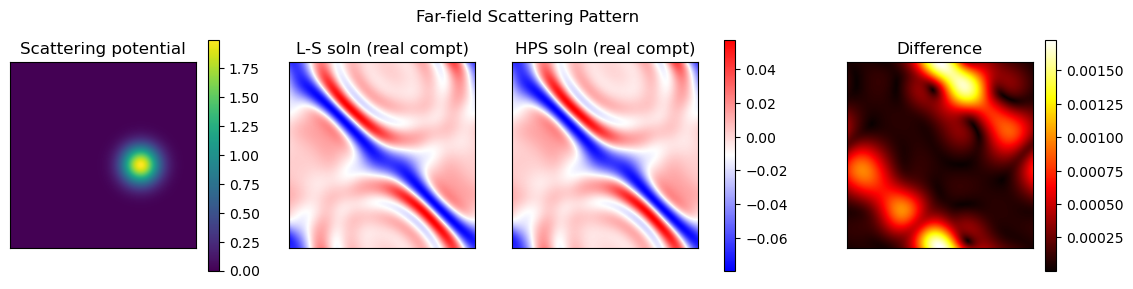

In [57]:
fig, axes = plot_row(
    [ref_main_q_unif, np.real(d_rs_low), np.real(d_rs_hps_wrapped), np.abs(d_rs_hps - d_rs_low)],
    ["Scattering potential", "L-S soln (real compt)", "HPS soln (real compt)", "Difference"],
    cmap_group_lens=[1,2,1],
    group_cmaps=["viridis", "bwr", "hot"],
    subplot_width=3,
    subplot_height=3,
)
fig.suptitle(f"Far-field Scattering Pattern")
for ax in axes:
    ax.set_aspect(1)
plt.show()